#  Fish Track Processing Jupyter Notebook

### Import all of the functions, and read previously saved data

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline  
from __future__ import absolute_import
from extract_data import extract_data
from finbeat_calc import finbeat_calc
from store_data import store_data
from read_data import read_data
from make_subset import make_subset
from plot_accel import plot_accel
from plot_track import plot_track
from check_plots import check_plots
from plot_analysis import plot_analysis
from sin_corr import sin_corr
from plot_fit_sine import plot_fit_sine
from fourier_analysis import fourier_analysis

# If you've never extracted the data before, uncomment the next 2 lines, and comment out the code below them
# tracklist = extract_data()
# finbeats, finbeat_byP, finbeat_byT = finbeat_calc(tracklist.keys(),tracklist)

# If you've extracted the data before, uncomment the next 2 lines, and comment out the code above them
# Read stored data
tracklist, finbeats, finbeat_byP, finbeat_byT = read_data('data.pickle')

### Make useful subsets for later use in functions

In [2]:
bass_subset = make_subset(group_by1='species', identifier1='Bass', tracklist=tracklist)
bass_burst_subset = make_subset(group_by1 = 'species', identifier1='Bass', 
                                 tracklist=tracklist, group_by2 = 'behavior', identifier2='B')
bass_steady_subset = make_subset(group_by1 = 'species', identifier1='Bass', 
                                 tracklist=tracklist, group_by2 = 'behavior', identifier2='S')
bass_linacc_subset = make_subset(group_by1 = 'species', identifier1='Bass', 
                                 tracklist=tracklist, group_by2 = 'behavior', identifier2='A')

trout_subset = make_subset(group_by1 = 'species', identifier1 ='BTrout', tracklist=tracklist)
trout_burst_subset = make_subset(group_by1 = 'species', identifier1='BTrout', 
                                 tracklist=tracklist, group_by2 = 'behavior', identifier2='B')
trout_steady_subset = make_subset(group_by1 = 'species', identifier1='BTrout', 
                                 tracklist=tracklist, group_by2 = 'behavior', identifier2='S')
trout_linacc_subset = make_subset(group_by1 = 'species', identifier1='BTrout', 
                                 tracklist=tracklist, group_by2 = 'behavior', identifier2='A')

### Fit sine waves to data, find the correlations, plot the fit

In [47]:
bass_steady_corr_w_sin = sin_corr(bass_steady_subset, tracklist, finbeat_byT)
trout_steady_corr_w_sin = sin_corr(trout_steady_subset, tracklist, finbeat_byT)

bass_linacc_corr_w_sin = sin_corr(bass_linacc_subset, tracklist, finbeat_byT)
trout_linacc_corr_w_sin = sin_corr(trout_linacc_subset, tracklist, finbeat_byT)

bass_burst_corr_w_sin = sin_corr(bass_burst_subset, tracklist, finbeat_byT)
trout_burst_corr_w_sin = sin_corr(trout_burst_subset, tracklist, finbeat_byT)


#plot_fit_sine(trout_subset, tracklist, corr_w_sin)

C:\Anaconda3\lib\site-packages\numpy\core\_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
C:\Anaconda3\lib\site-packages\numpy\core\_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:427: RuntimeWarning: Number of calls to function has reached maxfev = 1000.
  warnings.warn(errors[info][0], RuntimeWarning)
C:\Anaconda3\lib\site-packages\scipy\stats\stats.py:3038: RuntimeWarning: invalid value encountered in double_scalars
  t_squared = r**2 * (df / ((1.0 - r) * (1.0 + r)))
C:\Anaconda3\lib\site-packages\scipy\stats\stats.py:5084: RuntimeWarning: invalid value encountered in less
  x = np.where(x < 1.0, x, 1.0)  # if x > 1 then return 1.0


### Messing around with correlation heatmaps

In [48]:
bass_steady_corr_sort = bass_steady_corr_w_sin.sort_values(by=['Behavior', 'InitSpd', 'Pearsons'], ascending = False)
trout_steady_corr_sort = trout_steady_corr_w_sin.sort_values(by=['Behavior', 'InitSpd', 'Pearsons'], ascending = False)

bass_linacc_corr_sort = bass_linacc_corr_w_sin.sort_values(by=['Behavior', 'InitSpd', 'Pearsons'], ascending = False)
trout_linacc_corr_sort = trout_linacc_corr_w_sin.sort_values(by=['Behavior', 'InitSpd', 'Pearsons'], ascending = False)

bass_burst_corr_sort = bass_burst_corr_w_sin.sort_values(by=['Behavior', 'InitSpd', 'Pearsons'], ascending = False)
trout_burst_corr_sort = trout_burst_corr_w_sin.sort_values(by=['Behavior', 'InitSpd', 'Pearsons'], ascending = False)


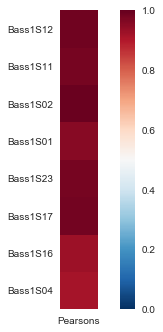

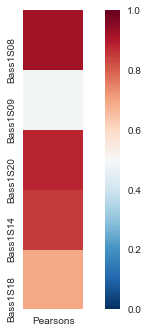

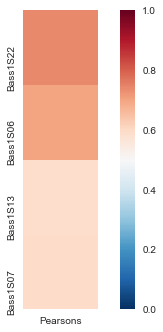

In [49]:
import pandas as pd
bass_steady_corr_sort= bass_steady_corr_sort.dropna(axis=0, how='any')
bass_steady_corr_sort['Pearsons']= bass_steady_corr_sort['Pearsons'].apply(pd.to_numeric)

bass_linacc_corr_sort= bass_linacc_corr_sort.dropna(axis=0, how='any')
bass_linacc_corr_sort['Pearsons']= bass_linacc_corr_sort['Pearsons'].apply(pd.to_numeric)

bass_burst_corr_sort= bass_burst_corr_sort.dropna(axis=0, how='any')
bass_burst_corr_sort['Pearsons']= bass_burst_corr_sort['Pearsons'].apply(pd.to_numeric)

import seaborn as sns
import matplotlib.pyplot as plt
sns.heatmap(bass_steady_corr_sort[['Pearsons']], cmap = 'RdBu_r', vmin = 0.0, vmax = 1.0, square = True)
plt.show()

sns.heatmap(bass_linacc_corr_sort[['Pearsons']], cmap = 'RdBu_r', vmin = 0.0, vmax = 1.0, square = True)
plt.show()

sns.heatmap(bass_burst_corr_sort[['Pearsons']], cmap = 'RdBu_r', vmin = 0.0, vmax = 1.0, square = True)
plt.show()

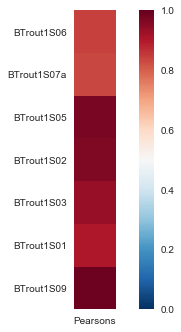

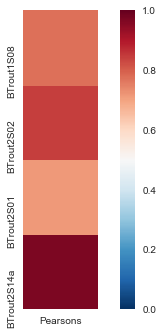

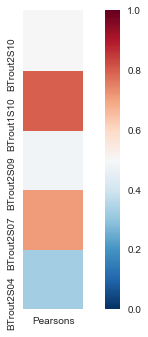

In [50]:
trout_steady_corr_sort= trout_steady_corr_sort.dropna(axis=0, how='any')
trout_steady_corr_sort['Pearsons']= trout_steady_corr_sort['Pearsons'].apply(pd.to_numeric)

trout_linacc_corr_sort= trout_linacc_corr_sort.dropna(axis=0, how='any')
trout_linacc_corr_sort['Pearsons']= trout_linacc_corr_sort['Pearsons'].apply(pd.to_numeric)

trout_burst_corr_sort= trout_burst_corr_sort.dropna(axis=0, how='any')
trout_burst_corr_sort['Pearsons']= trout_burst_corr_sort['Pearsons'].apply(pd.to_numeric)

sns.heatmap(trout_steady_corr_sort[['Pearsons']], cmap = 'RdBu_r', square = True, vmin =0.0, vmax=1.0)
plt.show()

sns.heatmap(trout_linacc_corr_sort[['Pearsons']], cmap = 'RdBu_r', square = True, vmin =0.0, vmax=1.0)
plt.show()

sns.heatmap(trout_burst_corr_sort[['Pearsons']], cmap = 'RdBu_r', square = True, vmin =0.0, vmax=1.0)
plt.show()

### Calculate pairwise max. cross-correlation and it's associated phase shift of FFTs

Note: There's something wrong here that has to do with relative lengths of each trial. Not sure this approach is valid

In [53]:
import numpy as np
import pandas as pd
import scipy
import peakutils

cross_corr = pd.DataFrame(data=None, index = bass_subset, columns = bass_subset)

for i in bass_subset:
        tailtip = tracklist[i]['data']['pt2y_smth']
        time = tracklist[i]['data'].index.values
        base = peakutils.baseline(tailtip, 3)  # Find linear bkgrd trend
        
        # Do the FFT using Scipy
        tailbeat_FFT = np.abs(np.fft.fft(tailtip - base))
      
        
        for j in bass_subset:
            tailtip2 = tracklist[j]['data']['pt2y_smth']
            if len(tailtip) < 1000 or len(tailtip2)< 1000:
                cross_corr[i][j] = np.nan
            else:
                time2 = tracklist[j]['data'].index.values
                base2 = peakutils.baseline(tailtip2, 3)  # Find linear bkgrd trend

                # Do the FFT using Scipy
                tailbeat_FFT2 = np.abs(np.fft.fft(tailtip2 - base2))            
                tailbeat_FFT_norm = (tailbeat_FFT - np.mean(tailbeat_FFT)) / (np.std(tailbeat_FFT)*len(tailbeat_FFT))
                tailbeat_FFT2_norm = (tailbeat_FFT2 - np.mean(tailbeat_FFT2)) / np.std(tailbeat_FFT2)
                corr_max = scipy.signal.correlate(tailbeat_FFT_norm, tailbeat_FFT2_norm, mode = 'valid')
                max_index = np.argmax(corr_max)
                #print(i, j, max_index, np.around(corr_max[max_index], decimals = 3))
                #cross_corr[i][j] = (np.around(corr_max[max_index], decimals = 3), max_index)
                cross_corr[i][j] = corr_max[max_index]
cross_corr
cross_corr.dropna(axis=(0,1), how="all", inplace=True)
cross_corr= cross_corr.apply(pd.to_numeric)

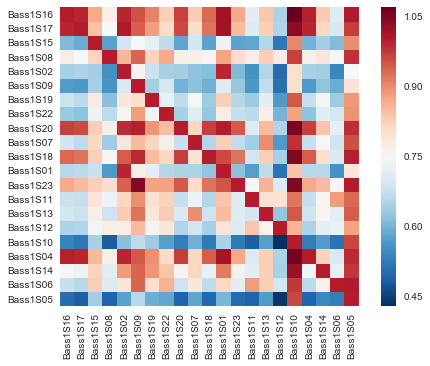

In [52]:
sns.heatmap(cross_corr,cmap = 'RdBu_r',square=True)

### Trying to figure out wavelets

In [ ]:
import matplotlib.pyplot as plt
import pywt 
from scipy import signal

testdata = tracklist['Bass1S09']['data']['pt2y_smth']
time = tracklist['Bass1S09']['data'].index.values
framerate = float(tracklist['Bass1S09']['FPS'])
scales = np.arange(2,20,1)


wavelet_choice = pywt.Wavelet('bior3.1')
print(wavelet_choice)
for i in np.arange(2,20,1):
    freq = pywt.scale2frequency(wavelet_choice, i)
    print(': scale=',i, ' freq=', freq)

In [ ]:
for name in pywt.wavelist(kind='discrete'):
    x = time
    data = testdata
    wavelet = name
    level = 1
    order = 'freq'
    interpolation = 'nearest'
    cmap = plt.cm.cool

    wp = pywt.WaveletPacket(data, wavelet, 'symmetric', maxlevel = level)
    nodes = wp.get_level(level, order = order)
    labels = [n.path for n in nodes]
    values = np.array([n.data for n in nodes], 'd')
    values = abs(values)
    fig = plt.figure()
    fig.subplots_adjust(hspace=0.2, bottom=.03, left=.07, right=.97, top=.92)
    ax = fig.add_subplot(2, 1, 1)
    ax.set_title("Data")
    ax.plot(x, data, 'b')
    ax.set_xlim(0, x[-1])

    ax = fig.add_subplot(2, 1, 2)
    ax.set_title("Wavelet packet coefficients at level %d" % level)
    ax.imshow(values, interpolation=interpolation, cmap=cmap, aspect="auto",
              origin="lower", extent=[0, 1, 0, len(values)])
    ax.set_yticks(np.arange(0.5, len(labels) + 0.5), labels)

    # Show spectrogram and wavelet packet coefficients
    fig2 = plt.figure()
    ax2 = fig2.add_subplot(211)
    ax2.specgram(data, NFFT=64, noverlap=32, Fs=2, cmap=cmap,
                 interpolation='bilinear')
    ax2.set_title("Spectrogram of signal")
    ax3 = fig2.add_subplot(212)
    ax3.imshow(values, origin='upper', extent=[-1, 1, -1, 1],
               interpolation='nearest')
    ax3.set_title("Wavelet packet coefficients")


    plt.show()



In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import pywt


x = np.linspace(0, 1, num=512)
data = np.sin(250 * np.pi * x**2)

wavelet = 'db2'
level = 4
order = "freq"  # other option is "normal"
interpolation = 'nearest'
cmap = plt.cm.cool

# Construct wavelet packet
wp = pywt.WaveletPacket(data, wavelet, 'symmetric', maxlevel=level)
nodes = wp.get_level(level, order=order)
labels = [n.path for n in nodes]
values = np.array([n.data for n in nodes], 'd')
values = abs(values)

# Show signal and wavelet packet coefficients
fig = plt.figure()
fig.subplots_adjust(hspace=0.2, bottom=.03, left=.07, right=.97, top=.92)
ax = fig.add_subplot(2, 1, 1)
ax.set_title("linchirp signal")
ax.plot(x, data, 'b')
ax.set_xlim(0, x[-1])

ax = fig.add_subplot(2, 1, 2)
ax.set_title("Wavelet packet coefficients at level %d" % level)
ax.imshow(values, interpolation=interpolation, cmap=cmap, aspect="auto",
          origin="lower", extent=[0, 1, 0, len(values)])
ax.set_yticks(np.arange(0.5, len(labels) + 0.5), labels)

# Show spectrogram and wavelet packet coefficients
fig2 = plt.figure()
ax2 = fig2.add_subplot(211)
ax2.specgram(data, NFFT=64, noverlap=32, Fs=2, cmap=cmap,
             interpolation='bilinear')
ax2.set_title("Spectrogram of signal")
ax3 = fig2.add_subplot(212)
ax3.imshow(values, origin='upper', extent=[-1, 1, -1, 1],
           interpolation='nearest')
ax3.set_title("Wavelet packet coefficients")


plt.show()